# Convert Apple Watch ENMO to Activity Counts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import os
import glob
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [2]:
csv_file_paths = sorted(glob.glob('raw_data/*.csv'))  # Update the directory path as needed

# Initialize an empty list to store the loaded CSV data
dirty_data = pd.DataFrame()


# We are splitting our data by person so the first 10 people as train and the last 4 as test
# Iterate through each file in the directory
for filepath in sorted(csv_file_paths):
    # print(filepath)
    if filepath.endswith(".csv"):  # Check if the file is a CSV
        # Load the CSV file into a pandas DataFrame
        df = pd.read_csv(filepath)
        df = df.dropna() # drop empty lines
        dirty_data = pd.concat([dirty_data, df])  
                  

In [3]:
# Reset the index
dirty_data = dirty_data.reset_index(drop=True)
dirty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48909 entries, 0 to 48908
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   timestamp                  48909 non-null  object 
 1   Actiwatch activity counts  48909 non-null  float64
 2   Actiware classification    48909 non-null  float64
 3   Apple Watch ENMO           48909 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.5+ MB


In [4]:
dirty_data

,timestamp,Actiwatch activity counts,Actiware classification,Apple Watch ENMO
0,01/01/2000 01:20:45,0.0,1.0,0.007234
1,01/01/2000 01:21:00,24.0,1.0,0.030109
2,01/01/2000 01:21:15,3.0,1.0,0.008785
3,01/01/2000 01:21:30,0.0,1.0,0.007893
4,01/01/2000 01:21:45,3.0,1.0,0.007761
...,...,...,...,...
48904,28/01/2000 08:56:30,113.0,1.0,0.071673
48905,28/01/2000 08:56:45,79.0,1.0,0.072491
48906,28/01/2000 08:57:00,88.0,1.0,0.079414
48907,28/01/2000 08:57:15,73.0,1.0,0.093463


In [5]:
dirty_data['Actiwatch activity counts'].describe()

count    48909.000000
mean         3.670265
std         22.043379
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        827.000000
Name: Actiwatch activity counts, dtype: float64

## Visualise Data

Text(0, 0.5, 'Actiwatch Activity Counts')

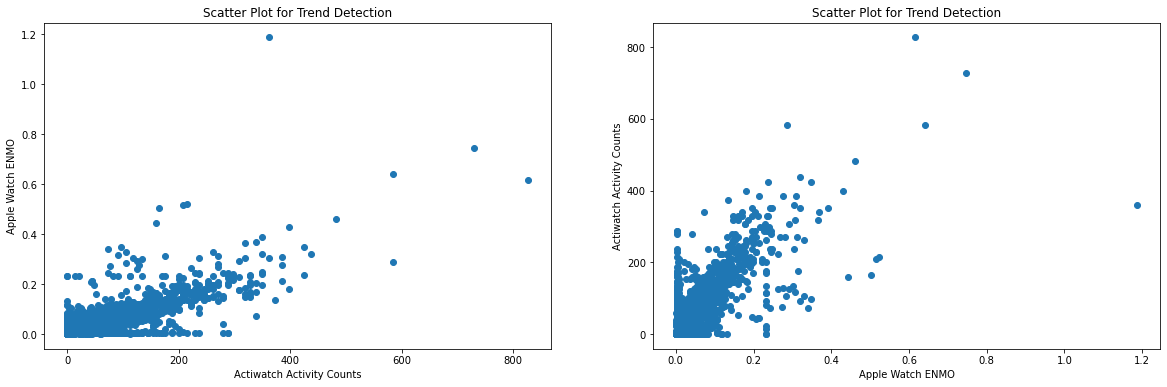

In [6]:
# Create a box plot
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
plt.scatter(dirty_data['Actiwatch activity counts'], dirty_data['Apple Watch ENMO'])
ax.set_title('Scatter Plot for Trend Detection')
ax.set_ylabel('Apple Watch ENMO')
ax.set_xlabel('Actiwatch Activity Counts')

ax = fig.add_subplot(1, 2, 2)
plt.scatter(dirty_data['Apple Watch ENMO'], dirty_data['Actiwatch activity counts'])
ax.set_title('Scatter Plot for Trend Detection')
ax.set_xlabel('Apple Watch ENMO')
ax.set_ylabel('Actiwatch Activity Counts')

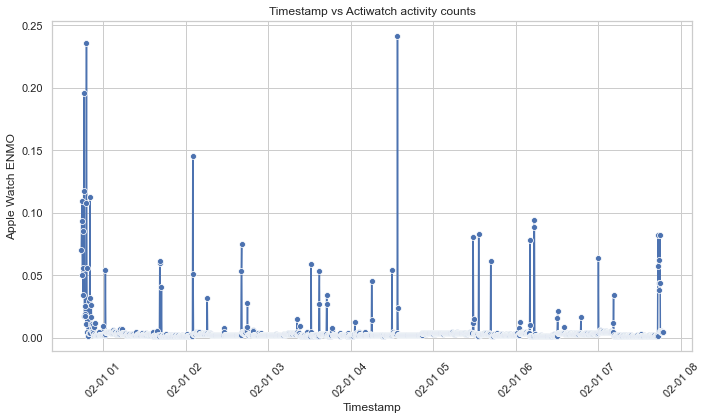

In [7]:
import seaborn as sns
# Convert the 'timestamp' column to datetime objects
test_df = pd.read_csv('raw_data/p02_n02_ready.csv')
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
# Set Seaborn style (optional)
sns.set(style="whitegrid")

# Plotting the data using Seaborn
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.lineplot(x='timestamp', y='Apple Watch ENMO', data=test_df, marker='o')

# Customize the plot (optional)
plt.title('Timestamp vs Actiwatch activity counts')
plt.xlabel('Timestamp')
plt.ylabel('Apple Watch ENMO')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Show the plot
plt.tight_layout()
plt.show()

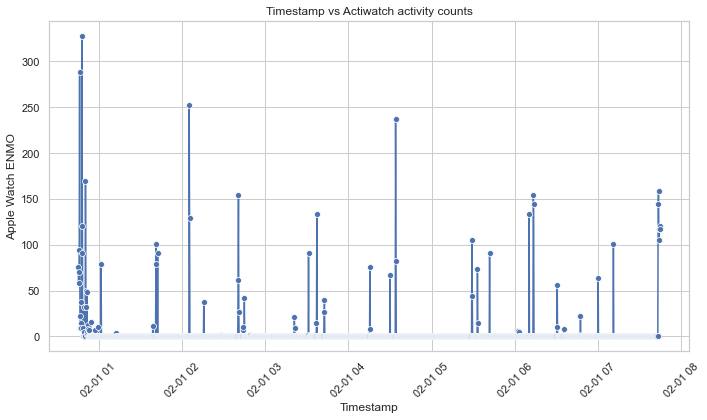

In [8]:
# Convert the 'timestamp' column to datetime objects
test_df = pd.read_csv('raw_data/p02_n02_ready.csv')
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
# Set Seaborn style (optional)
sns.set(style="whitegrid")

# Plotting the data using Seaborn
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.lineplot(x='timestamp', y='Actiwatch activity counts', data=test_df, marker='o')

# Customize the plot (optional)
plt.title('Timestamp vs Actiwatch activity counts')
plt.xlabel('Timestamp')
plt.ylabel('Apple Watch ENMO')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Show the plot
plt.tight_layout()
plt.show()

## Data Cleaning

In [9]:
to_filter = dirty_data[['Actiwatch activity counts','Apple Watch ENMO']]
duplicates_mask = to_filter['Apple Watch ENMO'].duplicated(keep=False)
filtered_df = to_filter[~duplicates_mask]

Text(0, 0.5, 'Actiwatch Activity Counts')

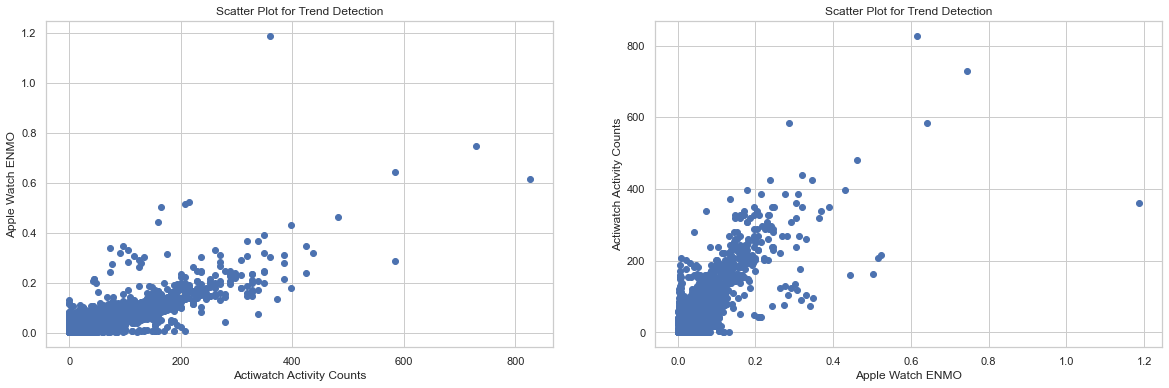

In [10]:
# Create a box plot
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
plt.scatter(filtered_df['Actiwatch activity counts'], filtered_df['Apple Watch ENMO'])
ax.set_title('Scatter Plot for Trend Detection')
ax.set_ylabel('Apple Watch ENMO')
ax.set_xlabel('Actiwatch Activity Counts')

ax = fig.add_subplot(1, 2, 2)
plt.scatter(filtered_df['Apple Watch ENMO'], filtered_df['Actiwatch activity counts'])
ax.set_title('Scatter Plot for Trend Detection')
ax.set_xlabel('Apple Watch ENMO')
ax.set_ylabel('Actiwatch Activity Counts')

In [11]:
filtered_df.shape

(46984, 2)

In [44]:
import numpy as np
import matplotlib.pyplot as plt
# signal = filtered_df['Apple Watch ENMO']
signal = dirty_data['Apple Watch ENMO']

In [45]:
from scipy.signal import butter, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_lowpass_filter(data, cutoff_frequency, epoch_length=15, original_sampling_rate=50, order=5):
    nyquist_frequency = original_sampling_rate / 2
    normalized_cutoff_frequency = cutoff_frequency / nyquist_frequency

    b, a = butter_lowpass(normalized_cutoff_frequency, 1.0 / epoch_length, order=order)
    y = filtfilt(b, a, data)
    return y

In [46]:
def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def apply_highpass_filter(data, cutoff_frequency, original_sampling_rate=50, order=5):
    nyquist_frequency = 0.5 * original_sampling_rate
    normalized_cutoff_frequency = cutoff_frequency / nyquist_frequency

    b, a = butter_highpass(normalized_cutoff_frequency, fs=1, order=order)
    y = filtfilt(b, a, data)
    return y

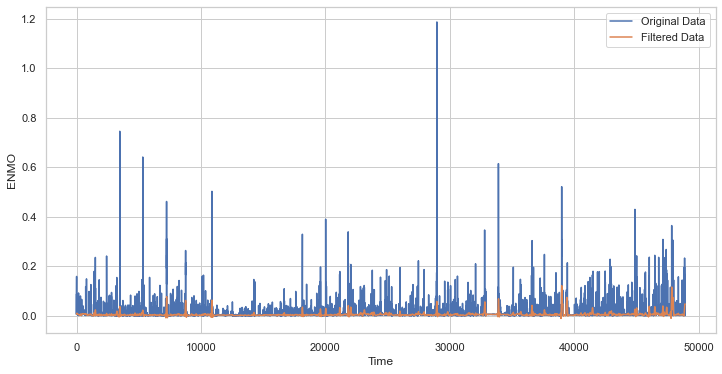

In [188]:
import matplotlib.pyplot as plt
original_data = signal
# Assuming 'original_data' is your raw ENMO data
filtered_data = apply_lowpass_filter(original_data, cutoff_frequency=0.02)  # Example cutoff frequency

plt.figure(figsize=(12, 6))
plt.plot(original_data, label='Original Data')
plt.plot(filtered_data, label='Filtered Data')
plt.xlabel('Time')
plt.ylabel('ENMO')
plt.legend()
plt.show()

### LInear Regression
#### Get Apple Watch Activity counts

In [189]:
# # Split the data into training and validation sets
# X_train = train['Apple Watch ENMO']  
# y_train = train['Actiwatch activity counts']

# X_val = val['Apple Watch ENMO']
# y_val = val['Actiwatch activity counts']

### Standardisation & Data Split

In [190]:
# Split the data into training and validation sets
# X = filtered_data
X = filtered_df['Apple Watch ENMO']
y = filtered_df['Actiwatch activity counts']
# y = dirty_data['Actiwatch activity counts'].copy()

# Add a constant term to X
X = sm.add_constant(X)

# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

In [191]:
print(X_train)

       const  Apple Watch ENMO
41671    1.0          0.003666
33319    1.0          0.006081
14106    1.0          0.001542
42855    1.0          0.002877
31672    1.0          0.102727
...      ...               ...
37280    1.0          0.003038
26103    1.0          0.002288
23782    1.0          0.001962
11628    1.0          0.003347
39456    1.0          0.004575

[32888 rows x 2 columns]


# Simple Linear Regression

### SLEEP WAKE VISUALISATION

In [192]:
X_train

,const,Apple Watch ENMO
41671,1.0,0.003666
33319,1.0,0.006081
14106,1.0,0.001542
42855,1.0,0.002877
31672,1.0,0.102727
...,...,...
37280,1.0,0.003038
26103,1.0,0.002288
23782,1.0,0.001962
11628,1.0,0.003347


### Model Training (SLR)

In [193]:
model = sm.OLS(y_train, X_train).fit()
print(model.params)

const                -2.210790
Apple Watch ENMO    953.888705
dtype: float64


In [194]:
print(model.summary())

                                OLS Regression Results                               
Dep. Variable:     Actiwatch activity counts   R-squared:                       0.706
Model:                                   OLS   Adj. R-squared:                  0.706
Method:                        Least Squares   F-statistic:                 7.890e+04
Date:                       Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                               00:01:02   Log-Likelihood:            -1.2769e+05
No. Observations:                      32888   AIC:                         2.554e+05
Df Residuals:                          32886   BIC:                         2.554e+05
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

### Model Evaluation (SLR)

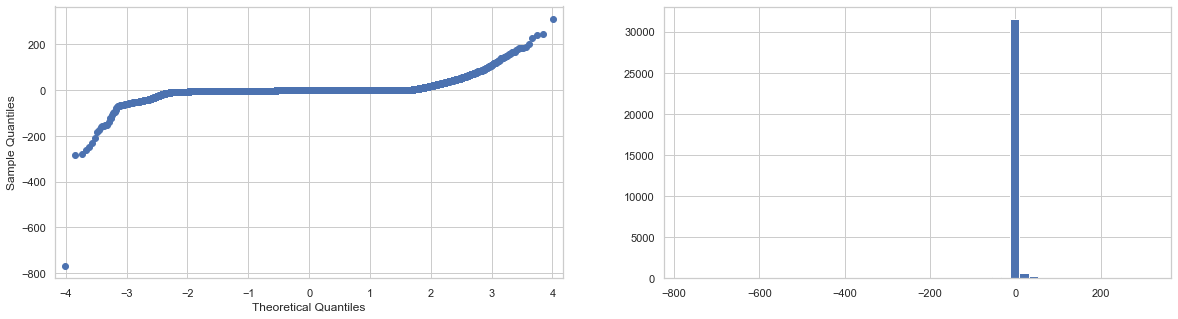

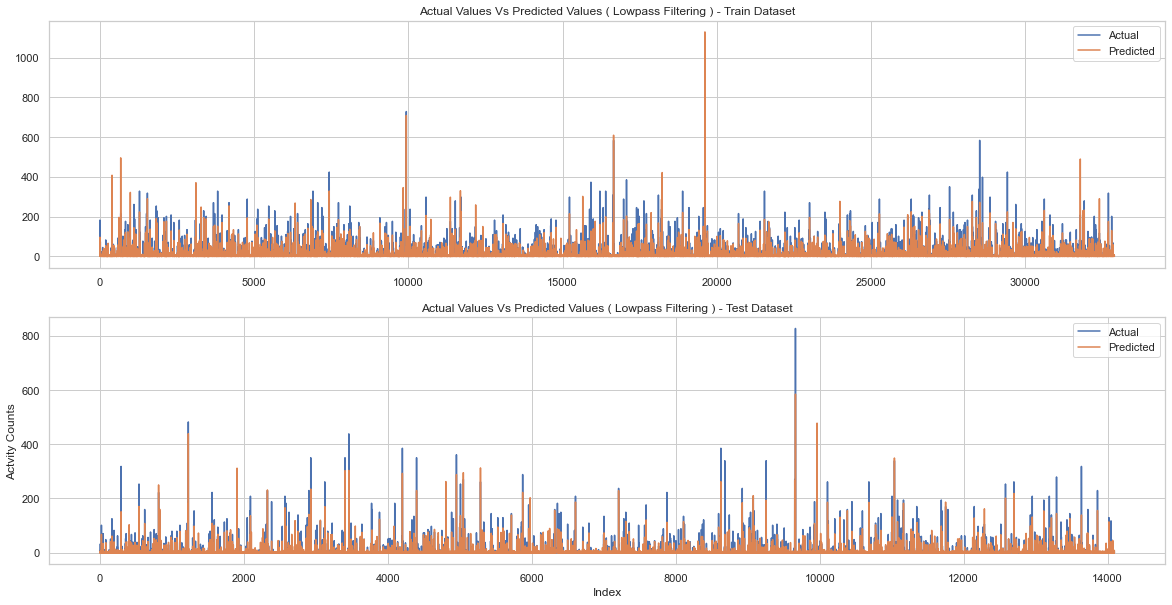

In [212]:
def plot_diagnoistics(trained_model, X_train, Y_train, X_test, Y_test):

    fig = plt.figure(figsize=[20, 5])
    ax = fig.add_subplot(1, 2, 1)
    f = sm.qqplot(trained_model.resid, ax=ax)
    ax = fig.add_subplot(1, 2, 2)
    ax.hist(trained_model.resid, 50)

    Y_train_pred = trained_model.predict(X_train)
    Y_test_pred = trained_model.predict(X_test)
    rmse_train = np.sqrt(np.mean((Y_train_pred - Y_train)**2))
    rmse_test = np.sqrt(np.mean((Y_test_pred - Y_test)**2))

    fig = plt.figure(figsize=[20, 10])
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(np.arange(len(Y_train_pred)), Y_train, label='Actual')
    ax.plot(np.arange(len(Y_train_pred)), Y_train_pred, label='Predicted')
    # ax.set_title('RMSE Train: {:.2f}'.format(rmse_train))
    ax.set_title('Actual Values Vs Predicted Values ( Lowpass Filtering ) - Train Dataset')
    ax.legend()
    
    ax = fig.add_subplot(2, 1, 2)
    ax.plot(np.arange(len(Y_test_pred)), Y_test, label='Actual')
    ax.plot(np.arange(len(Y_test_pred)), Y_test_pred, label='Predicted')
    ax.set_title('Actual Values Vs Predicted Values ( Lowpass Filtering ) - Test Dataset')
    ax.set_ylabel('Actvity Counts')
    ax.set_xlabel('Index')
    # ax.set_title('RMSE Test: {:.2f}'.format(rmse_test))
    ax.legend()
    
plot_diagnoistics(model, X_train, y_train, X_test, y_test)

### R2 Score

In [196]:
r2_train = r2_score(y_train, model.predict(X_train))
r2_test = r2_score(y_test, model.predict(X_test))

print('Linear Model\nTraining Data R2 Score: %f\nTesting Data R2 Score: %f' % (r2_train, r2_test))

Linear Model
Training Data R2 Score: 0.705815
Testing Data R2 Score: 0.769506


## Create The Data Set With Total Sleep time

In [197]:
# X2 = dirty_data['Apple Watch ENMO']
X2 = filtered_data
X2 = sm.add_constant(X2)
Predicted_Apple_Activity_Count = model.predict(X2)  
        
#Round all the numbers
Predicted_Apple_Activity_Count = list(map(round, Predicted_Apple_Activity_Count))

# Set all negative values to 0 using list comprehension
Predicted_Apple_Activity_Count = [num if num >= 0 else 0 for num in Predicted_Apple_Activity_Count]

# Count the number of negative values using list comprehension
count_negative = len([num for num in Predicted_Apple_Activity_Count if num < 0])

print("Number of negative values in the list:", count_negative)
print(len(Predicted_Apple_Activity_Count))

Number of negative values in the list: 0
48909


### Set Everything Before and after the first 5 minutes of slepp to wake.

# Sleep Wake Classification

In [198]:
new_data = dirty_data.copy()
duplicates_mask = new_data['Apple Watch ENMO'].duplicated(keep=False)
new_data = new_data[~duplicates_mask]

In [199]:
new_data['Apple active counts'] = Predicted_Apple_Activity_Count
new_data.head()

,timestamp,Actiwatch activity counts,Actiware classification,Apple Watch ENMO,Apple active counts
0,01/01/2000 01:20:45,0.0,1.0,0.007234,5
1,01/01/2000 01:21:00,24.0,1.0,0.030109,5
2,01/01/2000 01:21:15,3.0,1.0,0.008785,5
3,01/01/2000 01:21:30,0.0,1.0,0.007893,5
4,01/01/2000 01:21:45,3.0,1.0,0.007761,6


In [200]:
new_data.shape

(48909, 5)

In [201]:
new_data

,timestamp,Actiwatch activity counts,Actiware classification,Apple Watch ENMO,Apple active counts
0,01/01/2000 01:20:45,0.0,1.0,0.007234,5
1,01/01/2000 01:21:00,24.0,1.0,0.030109,5
2,01/01/2000 01:21:15,3.0,1.0,0.008785,5
3,01/01/2000 01:21:30,0.0,1.0,0.007893,5
4,01/01/2000 01:21:45,3.0,1.0,0.007761,6
...,...,...,...,...,...
48904,28/01/2000 08:56:30,113.0,1.0,0.071673,43
48905,28/01/2000 08:56:45,79.0,1.0,0.072491,43
48906,28/01/2000 08:57:00,88.0,1.0,0.079414,43
48907,28/01/2000 08:57:15,73.0,1.0,0.093463,43


## Total Activity Counts

In [202]:
def totalCounts(ae):
    total = 0

    # Calculate the summation from i = -8 to i = -5
    for i in range(-8, -4):
        total += 0.04 * ae[i]

    # Calculate the summation from i = -4 to i = -1
    for i in range(-4, 0):
        total += 0.2 * ae[i]

    # Add the constant term 4*ae
    total += 4 * ae[0]

    # Calculate the summation from i = 1 to i = 4
    for i in range(1, 5):
        total += 0.2 * ae[i]

    # Calculate the summation from i = 5 to i = 8
    for i in range(5, 9):
        total += 0.04 * ae[i]

    return total

# Sample usage
ae = [180,161,5,4,3,3,2,1,1]  # sample values for illustration
print(totalCounts(ae))
print(ae)

763.2
[180, 161, 5, 4, 3, 3, 2, 1, 1]


In [203]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48909 entries, 0 to 48908
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   timestamp                  48909 non-null  object 
 1   Actiwatch activity counts  48909 non-null  float64
 2   Actiware classification    48909 non-null  float64
 3   Apple Watch ENMO           48909 non-null  float64
 4   Apple active counts        48909 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 1.9+ MB


In [204]:
# def calculate_total_counts(df, column,LB,UB):
#     for index, value in enumerate(df[column]):
#         if index >= LB and index <= len(df[column]) - UB:
#             ae = list(df[column][index - 8:index + 9])
#             df.at[index, 'Total Counts'] = totalCounts(ae)
#         else:
#             df.at[index, 'Total Counts'] = 60
#     return df

def calculate_total_counts(df, column):
    n = 0
    for index, value in enumerate(df[column]):
        if 8 <= index and index <= len(df[column]) - 9:
            ae = list(df[column][index - 8:index + 9])
            df.at[index, 'Total Counts'] = totalCounts(ae)
        elif index < 8:
            ae = list(df[column][index - n:index + 9])
            df.at[index, 'Total Counts'] = totalCounts(ae)
            n += 1
        elif index > len(df[column]) - 9:
            ae = list(df[column][index - 8:])
            df.at[index, 'Total Counts'] = totalCounts(ae)
            
            
    return df

calculate_total_counts(new_data, 'Apple active counts')

,timestamp,Actiwatch activity counts,Actiware classification,Apple Watch ENMO,Apple active counts,Total Counts
0,01/01/2000 01:20:45,0.0,1.0,0.007234,5,30.80
1,01/01/2000 01:21:00,24.0,1.0,0.030109,5,31.04
2,01/01/2000 01:21:15,3.0,1.0,0.008785,5,31.28
3,01/01/2000 01:21:30,0.0,1.0,0.007893,5,31.52
4,01/01/2000 01:21:45,3.0,1.0,0.007761,6,31.72
...,...,...,...,...,...,...
48904,28/01/2000 08:56:30,113.0,1.0,0.071673,43,254.56
48905,28/01/2000 08:56:45,79.0,1.0,0.072491,43,254.56
48906,28/01/2000 08:57:00,88.0,1.0,0.079414,43,254.56
48907,28/01/2000 08:57:15,73.0,1.0,0.093463,43,254.56


In [205]:
new_data['Actiware classification'].value_counts()

0.0    45023
1.0     3886
Name: Actiware classification, dtype: int64

In [206]:
# Set up parameters
threshold = 40  # You can try different thresholds (e.g., 20 or 40)

# Reset the index of the DataFrame 'new_data'
new_data.reset_index(drop=True, inplace=True)

# Define the classification function
def classify_epoch(total_counts, threshold):
    if total_counts <= threshold:
        return 0  # Sleep
    else:
        return 1  # Wake

# Apply classification
new_data['Apple Classification'] = new_data['Total Counts'].apply(lambda x: classify_epoch(x, threshold))

In [207]:
# Evaluate the results using ground truth (Actiware classification)
accuracy = (new_data['Apple Classification'] == new_data['Actiware classification']).mean()
print(f'Accuracy: {accuracy:.4f}')

# # Save the results to a new CSV file
# new_data.to_csv('results.csv', index=False)

Accuracy: 0.8947


# Evaluating the data

In [166]:
def setWake(dataframe,column):
    target_index = 0 # the index of the epoch that starts the uninterupted sleep
    target_lock = False
    sleep_count = 0 
    sleep_duration = 20 # uninterupted sleep durationon epochs

    for index, data in dataframe[column].items():
        if sleep_count < sleep_duration:
            if target_lock is False and data == 0:
                target_index = index
                target_lock = True
            if data == 0:
                sleep_count += 1
            elif data == 1:
                sleep_count = 0
                target_lock = False
        elif sleep_count > sleep_duration:
            break;

    for index, data in dataframe[column].items():
        if index < target_index:
            dataframe.at[index, column] = 1
    # Print the target_index
    print("Starting Target Index:", target_index)
    
    target_index = 0 # the index of the epoch that starts the uninterupted sleep
    target_lock = False
    sleep_count = 0 
    sleep_duration = 20 # uninterupted sleep durationon epochs

    for index in range(len(dataframe) - 1, -1, -1):
        data = dataframe[column].iloc[index]
        if sleep_count < sleep_duration:
            if target_lock is False and data == 0:
                target_index = index
                target_lock = True
            if data == 0:
                sleep_count += 1
            elif data == 1:
                sleep_count = 0
                target_lock = False
        elif sleep_count > sleep_duration:
            break;

    for index, data in dataframe[column].items():
        if index > target_index:
            dataframe.at[index, column] = 1
    
    print("Ending Target Index:", target_index)

    return dataframe

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94     45023
         1.0       0.36      0.48      0.41      3886

    accuracy                           0.89     48909
   macro avg       0.66      0.70      0.68     48909
weighted avg       0.91      0.89      0.90     48909



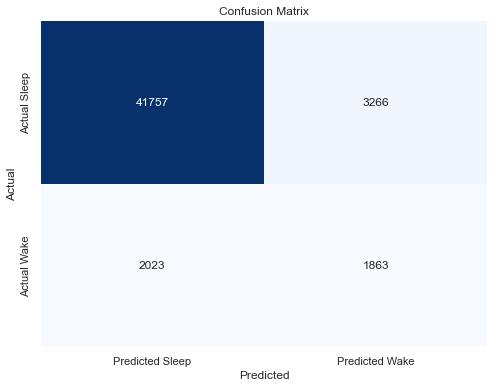

In [167]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

report = classification_report(new_data['Actiware classification'], new_data['Apple Classification'])

print(report)

conf_matrix = confusion_matrix(new_data['Actiware classification'], new_data['Apple Classification'])

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Sleep', 'Predicted Wake'],
            yticklabels=['Actual Sleep', 'Actual Wake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
new_data['Apple Classification'].value_counts()

0    45067
1     3842
Name: Apple Classification, dtype: int64

Number of negative values in the list: 0
1670
Starting Target Index: 30
Ending Target Index: 1669
Accuracy: 0.9251
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      1567
         1.0       0.36      0.26      0.30       103

    accuracy                           0.93      1670
   macro avg       0.65      0.62      0.63      1670
weighted avg       0.92      0.93      0.92      1670



,timestamp,Actiwatch activity counts,Actiware classification,Apple Watch ENMO,Apple active counts,Total Counts,Apple Classification
0,02/01/2000 00:46:15,288.0,1.0,0.195626,184,843.52,1
1,02/01/2000 00:46:30,22.0,1.0,0.017467,14,842.08,1
2,02/01/2000 00:46:45,9.0,1.0,0.019097,16,825.44,1
3,02/01/2000 00:47:00,15.0,1.0,0.017415,14,789.20,1
4,02/01/2000 00:47:15,38.0,1.0,0.025229,22,780.16,1
...,...,...,...,...,...,...,...
1665,02/01/2000 07:42:30,0.0,1.0,0.001742,0,25.60,0
1666,02/01/2000 07:42:45,0.0,1.0,0.001455,0,25.60,0
1667,02/01/2000 07:43:00,0.0,1.0,0.001397,0,25.60,0
1668,02/01/2000 07:43:15,144.0,1.0,0.082055,76,28.64,0


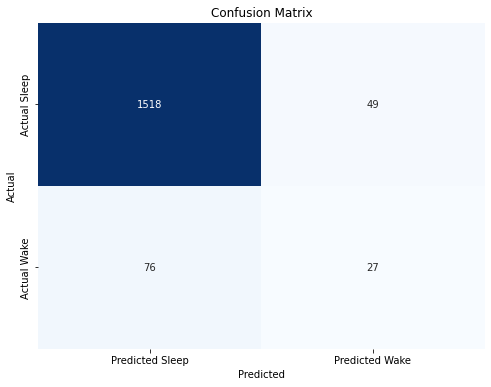

In [50]:
# We are splitting our data by person so the first 10 people as train and the last 4 as test
# Iterate through each file in the directory
# for filepath in sorted(csv_file_paths):
#     # print(filepath)
#     if filepath.endswith(".csv"):  # Check if the file is a CSV
#         # Load the CSV file into a pandas DataFrame
        
def EvaluateSleep(filepath):        
    df = pd.read_csv(filepath)
    df = df.dropna() # drop empty lines
    df = df.reset_index(drop=True)
    pred = df[['Apple Watch ENMO']]
    pred = sm.add_constant(pred)
    Predicted_Apple_Activity_Count = model.predict(pred)  
    pred = pred.reset_index(drop=True)

        
    #Round all the numbers
    Predicted_Apple_Activity_Count = list(map(round, Predicted_Apple_Activity_Count))

    # Set all negative values to 0 using list comprehension
    Predicted_Apple_Activity_Count = [num if num >= 0 else 0 for num in Predicted_Apple_Activity_Count]

    # Count the number of negative values using list comprehension
    count_negative = len([num for num in Predicted_Apple_Activity_Count if num < 0])

    print("Number of negative values in the list:", count_negative)
    print(len(Predicted_Apple_Activity_Count))
    
    df['Apple active counts'] = Predicted_Apple_Activity_Count
    
    threshold = 40
    
    final_df = calculate_total_counts(df,'Apple active counts')
    final_df['Apple Classification'] = final_df['Total Counts'].apply(lambda x: classify_epoch(x, threshold))
    
    final_df = setWake(final_df, 'Apple Classification')
    
    accuracy = (final_df['Apple Classification'] == final_df['Actiware classification']).mean()
    print(f'Accuracy: {accuracy:.4f}')
    
    report = classification_report(final_df['Actiware classification'], final_df['Apple Classification'])

    print(report)

    conf_matrix = confusion_matrix(final_df['Actiware classification'], final_df['Apple Classification'])
    
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Sleep', 'Predicted Wake'],
                yticklabels=['Actual Sleep', 'Actual Wake'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
        
    return final_df

EvaluateSleep('raw_data/p02_n02_ready.csv')

Starting Target Index: 69
Ending Target Index: 1505
Starting Target Index: 30
Ending Target Index: 1669
Starting Target Index: 9
Ending Target Index: 2066
Starting Target Index: 91
Ending Target Index: 1978
Starting Target Index: 33
Ending Target Index: 1463
Starting Target Index: 17
Ending Target Index: 2088
Starting Target Index: 56
Ending Target Index: 1674
Starting Target Index: 0
Ending Target Index: 1690
Starting Target Index: 35
Ending Target Index: 1492
Starting Target Index: 0
Ending Target Index: 2384
Starting Target Index: 37
Ending Target Index: 1871
Starting Target Index: 31
Ending Target Index: 1809
Starting Target Index: 38
Ending Target Index: 1928
Starting Target Index: 9
Ending Target Index: 1487
Starting Target Index: 0
Ending Target Index: 2057
Starting Target Index: 33
Ending Target Index: 1527
Starting Target Index: 25
Ending Target Index: 1832
Starting Target Index: 21
Ending Target Index: 1936
Starting Target Index: 117
Ending Target Index: 2896
Starting Target 

Text(0.5, 1.0, 'Confusion Matrix')

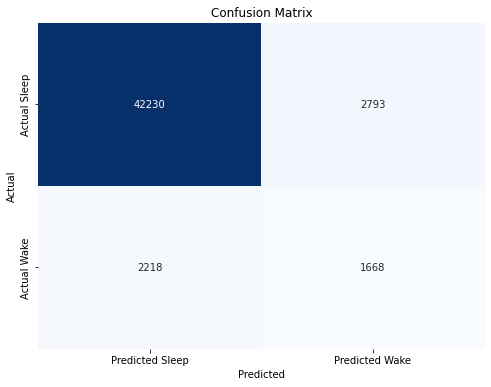

In [51]:
def EvaluateAllSleep():
    final_df = pd.DataFrame()
    for filepath in sorted(csv_file_paths):
    # print(filepath)
        if filepath.endswith(".csv"):  # Check if the file is a CSV
            # Load the CSV file into a pandas DataFrame
            df = pd.read_csv(filepath)
            df = df.dropna() # drop empty lines
            df = df.reset_index(drop=True)
            pred = df[['Apple Watch ENMO']]
            pred = sm.add_constant(pred)
            Predicted_Apple_Activity_Count = model.predict(pred)  
            pred = pred.reset_index(drop=True)

            #Round all the numbers
            Predicted_Apple_Activity_Count = list(map(round, Predicted_Apple_Activity_Count))

            # Set all negative values to 0 using list comprehension
            Predicted_Apple_Activity_Count = [num if num >= 0 else 0 for num in Predicted_Apple_Activity_Count]

            # Count the number of negative values using list comprehension
            count_negative = len([num for num in Predicted_Apple_Activity_Count if num < 0])

            # print("Number of negative values in the list:", count_negative)
            # print(len(Predicted_Apple_Activity_Count))

            df['Apple active counts'] = Predicted_Apple_Activity_Count

            threshold = 40
            
            new_df = calculate_total_counts(df,'Apple active counts')
            new_df['Apple Classification'] = new_df['Total Counts'].apply(lambda x: classify_epoch(x, threshold))
            new_df = setWake(new_df, 'Apple Classification')
            final_df = pd.concat([final_df, new_df])  
        
    return final_df

final_df = EvaluateAllSleep()

accuracy = (final_df['Apple Classification'] == final_df['Actiware classification']).mean()
print(f'Accuracy: {accuracy:.4f}')

report = classification_report(final_df['Actiware classification'], final_df['Apple Classification'])
print(report)

conf_matrix = confusion_matrix(final_df['Actiware classification'], final_df['Apple Classification'])

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted Sleep', 'Predicted Wake'],
                    yticklabels=['Actual Sleep', 'Actual Wake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

## Average Sleep Duration - Accross all participants (Actiwatch vs Apple)

In [52]:
final_df['Apple Classification'].value_counts()

0    44448
1     4461
Name: Apple Classification, dtype: int64

## Sleep Visualisation (Actiwatch vs Apple)

In [53]:
def SleepVisualisation():
    columns = ['Patient','Apple Watch TST','Apple Watch TWT', 'Acti Watch TST','Acti Watch TWT', 'Apple Watch Accuracy']
    sleep_df = pd.DataFrame(columns=columns)
    for filepath in sorted(csv_file_paths):
    # print(filepath)
        if filepath.endswith(".csv"):  # Check if the file is a CSV
            # Load the CSV file into a pandas DataFrame
            df = pd.read_csv(filepath)
            df = df.dropna() # drop empty lines
            df = df.reset_index(drop=True)
            pred = df[['Apple Watch ENMO']]
            pred = sm.add_constant(pred)
            Predicted_Apple_Activity_Count = model.predict(pred)  
            pred = pred.reset_index(drop=True)

            #Round all the numbers
            Predicted_Apple_Activity_Count = list(map(round, Predicted_Apple_Activity_Count))

            # Set all negative values to 0 using list comprehension
            Predicted_Apple_Activity_Count = [num if num >= 0 else 0 for num in Predicted_Apple_Activity_Count]

            # Count the number of negative values using list comprehension
            count_negative = len([num for num in Predicted_Apple_Activity_Count if num < 0])

            # print("Number of negative values in the list:", count_negative)
            # print(len(Predicted_Apple_Activity_Count))

            df['Apple active counts'] = Predicted_Apple_Activity_Count

            threshold = 40
            
            new_df = calculate_total_counts(df,'Apple active counts')
            new_df['Apple Classification'] = new_df['Total Counts'].apply(lambda x: classify_epoch(x, threshold))
            new_df = setWake(new_df, 'Apple Classification')
            accuracy = (new_df['Apple Classification'] == new_df['Actiware classification']).mean()
            apple_sum = (new_df['Apple Classification'] == 0).sum()
            acti_sum = (new_df['Actiware classification'] == 0).sum()
            apple_wake_sum = new_df['Apple Classification'].sum()
            acti_wake_sum = new_df['Actiware classification'].sum()
            print(f'Accuracy: {accuracy:.4f}')
            patient = filepath.replace("_ready.csv", "").replace("raw_data/","") 
            new_row_data = {'Patient': patient,'Apple Watch TST': apple_sum,'Apple Watch TWT': apple_wake_sum, 'Acti Watch TST' : acti_sum,'Acti Watch TWT': acti_wake_sum, 'Apple Watch Accuracy' : accuracy}
            sleep_df = sleep_df.append(new_row_data, ignore_index=True)
            # final_df = pd.concat([final_df, new_df])  
        
    return sleep_df

sleep_df = SleepVisualisation()

Starting Target Index: 69
Ending Target Index: 1505
Accuracy: 0.8931
Starting Target Index: 30
Ending Target Index: 1669
Accuracy: 0.9251
Starting Target Index: 9
Ending Target Index: 2066
Accuracy: 0.9139


/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)


Starting Target Index: 91
Ending Target Index: 1978
Accuracy: 0.9183
Starting Target Index: 33
Ending Target Index: 1463
Accuracy: 0.9028
Starting Target Index: 17
Ending Target Index: 2088
Accuracy: 0.9275


/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)


Starting Target Index: 56
Ending Target Index: 1674
Accuracy: 0.9439
Starting Target Index: 0
Ending Target Index: 1690
Accuracy: 0.9728
Starting Target Index: 35
Ending Target Index: 1492
Accuracy: 0.9478


/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)


Starting Target Index: 0
Ending Target Index: 2384
Accuracy: 0.9344
Starting Target Index: 37
Ending Target Index: 1871
Accuracy: 0.9380
Starting Target Index: 31
Ending Target Index: 1809
Accuracy: 0.9442


/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)


Starting Target Index: 38
Ending Target Index: 1928
Accuracy: 0.8664
Starting Target Index: 9
Ending Target Index: 1487
Accuracy: 0.8544
Starting Target Index: 0
Ending Target Index: 2057
Accuracy: 0.9133


/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)


Starting Target Index: 33
Ending Target Index: 1527
Accuracy: 0.8892
Starting Target Index: 25
Ending Target Index: 1832
Accuracy: 0.8691
Starting Target Index: 21
Ending Target Index: 1936
Accuracy: 0.8299


/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)


Starting Target Index: 117
Ending Target Index: 2896
Accuracy: 0.9191
Starting Target Index: 17
Ending Target Index: 1875
Accuracy: 0.8872
Starting Target Index: 17
Ending Target Index: 1385
Accuracy: 0.9055


/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)


Starting Target Index: 115
Ending Target Index: 2420
Accuracy: 0.8722
Starting Target Index: 132
Ending Target Index: 1378
Accuracy: 0.8378
Starting Target Index: 76
Ending Target Index: 1963
Accuracy: 0.8862


/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)


Starting Target Index: 52
Ending Target Index: 1586
Accuracy: 0.8547
Starting Target Index: 21
Ending Target Index: 1336
Accuracy: 0.8090
Starting Target Index: 90
Ending Target Index: 931
Accuracy: 0.7873


/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)
/var/folders/46/w6ssnrz90jd99dt2brnl5b2m0000gn/T/ipykernel_51294/2611440715.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sleep_df = sleep_df.append(new_row_data, ignore_index=True)


In [298]:
sleep_df

,Patient,Apple Watch TST,Apple Watch TWT,Acti Watch TST,Acti Watch TWT,Apple Watch Accuracy
0,p02_n01,1377,129,1424,82.0,0.891766
1,p02_n02,1592,78,1567,103.0,0.923952
2,p03_n01,1933,134,1927,140.0,0.913885
3,p03_n02,1848,136,1886,98.0,0.918347
4,p04_n01,1382,161,1434,109.0,0.902787
5,p04_n02,2005,105,2002,108.0,0.927488
6,p05_n01,1596,79,1639,36.0,0.943284
7,p05_n02,1668,23,1663,28.0,0.972206
8,p06_n01,1428,65,1434,59.0,0.946417
9,p06_n02,2307,100,2305,102.0,0.934358


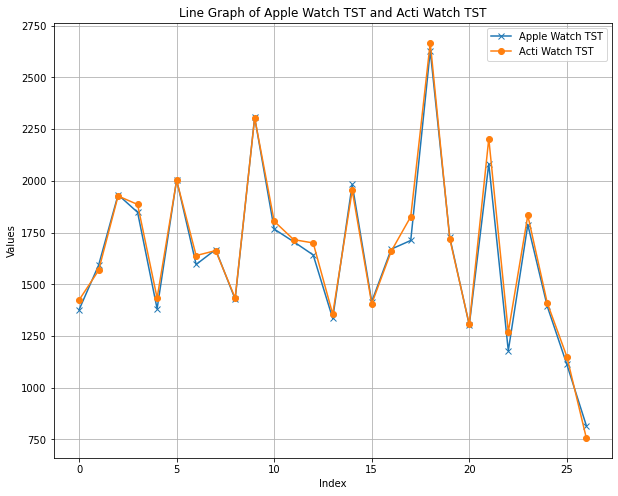

In [299]:
plt.figure(figsize=(10, 8))
plt.plot(sleep_df['Apple Watch TST'], label='Apple Watch TST', marker='x')
plt.plot(sleep_df['Acti Watch TST'], label='Acti Watch TST', marker='o')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Line Graph of Apple Watch TST and Acti Watch TST')
plt.legend()  # Show legend to identify each line
plt.grid(True)  # Add gridlines for better readability
plt.show()

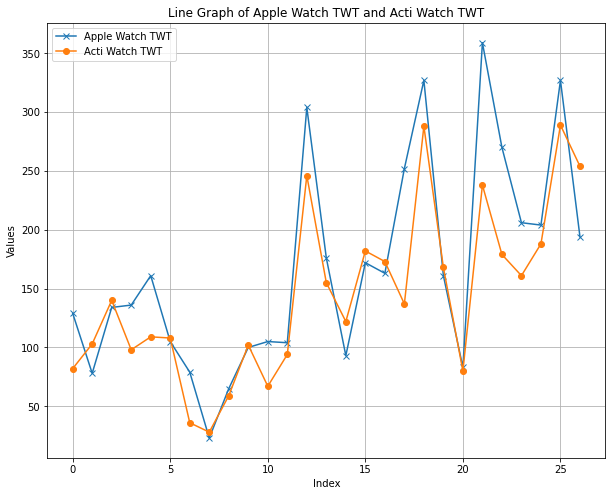

In [300]:
plt.figure(figsize=(10, 8))
plt.plot(sleep_df['Apple Watch TWT'], label='Apple Watch TWT', marker='x')
plt.plot(sleep_df['Acti Watch TWT'], label='Acti Watch TWT', marker='o')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Line Graph of Apple Watch TWT and Acti Watch TWT')
plt.legend()  # Show legend to identify each line
plt.grid(True)  # Add gridlines for better readability
plt.show()